In [2]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
#显示Dateframe所有列(参数设置为None代表显示所有行，也可以自行设置数字)
pd.set_option('display.max_columns',None)
#显示Dateframe所有行
pd.set_option('display.max_rows',None)
#设置Dataframe数据的显示长度，默认为50
pd.set_option('max_colwidth',200)
#不显示科学计数法，保留5位小数
pd.set_option('display.float_format', lambda x: '%.5f' % x)
from IPython.display import clear_output
from joblib import *
import numpy as np
import os
from tqdm import tqdm
from alpha_factors.Alpha158 import get_factors
import mplfinance as mpf

In [3]:
path = 'C:\\Users\\budin\\Desktop\\强化学习\\螺纹钢\\5分钟 - 副本\\数据\\'
dir_list = os.listdir(path)
train_df = pd.DataFrame()
for i in range(len(dir_list)):
    if 'train' in dir_list[i]:
        tmp_df = pd.read_csv(path+dir_list[i])
        train_df = train_df.append(tmp_df)
    else:
        pass
train_df = train_df.drop(columns='Unnamed: 0').rename(columns={'symbol':'underlaying_symbols', 'datetime': 'date'})
train_df['tic'] = ['RB']*len(train_df)
train_df = train_df[['date', 'tic', 'underlaying_symbols', 'open', 'high', 'low', 'close', 'volume', 'open_oi', 'close_oi']]
tickers = ['RB']

train_df.shape, train_df.head(5), train_df.dtypes

((6558, 10),
                   date tic underlaying_symbols       open       high  \
 0  2022-08-24 21:00:00  RB         SHFE.rb2210 4082.00000 4089.00000   
 1  2022-08-24 21:05:00  RB         SHFE.rb2210 4089.00000 4100.00000   
 2  2022-08-24 21:10:00  RB         SHFE.rb2210 4086.00000 4095.00000   
 3  2022-08-24 21:15:00  RB         SHFE.rb2210 4085.00000 4090.00000   
 4  2022-08-24 21:20:00  RB         SHFE.rb2210 4084.00000 4091.00000   
 
          low      close      volume       open_oi      close_oi  
 0 4081.00000 4086.00000 45466.00000 1289350.00000 1288077.00000  
 1 4083.00000 4086.00000 65069.00000 1288077.00000 1286786.00000  
 2 4082.00000 4085.00000 23530.00000 1286786.00000 1285704.00000  
 3 4079.00000 4084.00000 18618.00000 1285704.00000 1284464.00000  
 4 4082.00000 4091.00000 16848.00000 1284464.00000 1283701.00000  ,
 date                    object
 tic                     object
 underlaying_symbols     object
 open                   float64
 high           

# Reduce Contract Change Gap

In [4]:
contracts = train_df['underlaying_symbols'].unique()
indexes = []
for i in range(len(contracts)):
    tmp_df = train_df[train_df['underlaying_symbols']==contracts[i]]
    tmp_index = tmp_df.index
    indexes.append([tmp_index])
    
indexes

[[Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
              ...
              210, 211, 212, 213, 214, 215, 216, 217, 218, 219],
             dtype='int64', length=220)],
 [Int64Index([ 220,  221,  222,  223,  224,  225,  226,  227,  228,  229,
              ...
              4127, 4128, 4129, 4130, 4131, 4132, 4133, 4134, 4135, 4136],
             dtype='int64', length=3917)],
 [Int64Index([4137, 4138, 4139, 4140, 4141, 4142, 4143, 4144, 4145, 4146,
              ...
              6548, 6549, 6550, 6551, 6552, 6553, 6554, 6555, 6556, 6557],
             dtype='int64', length=2421)]]

## Inspect Individual Price Gaps 

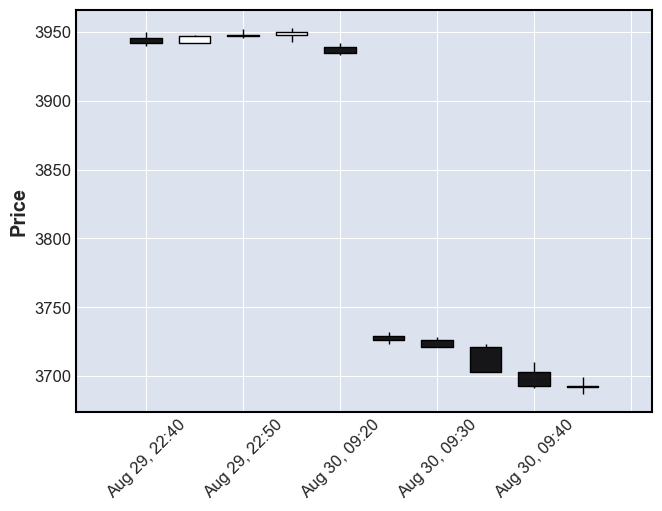

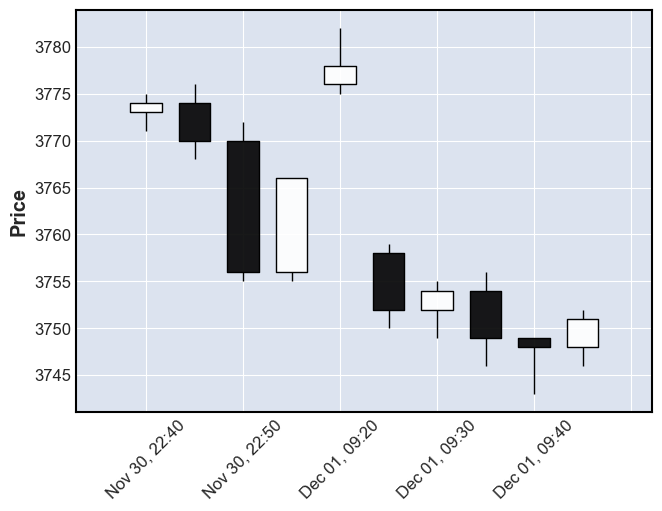

In [5]:
for i in range(1, len(contracts)):
    last_index_end = indexes[i-1][0][-5]
    this_index_start = indexes[i][0][5]
    tmp_df = train_df.iloc[last_index_end:this_index_start].set_index('date')
    tmp_df.index = pd.to_datetime(tmp_df.index)
    mpf.plot(tmp_df, type='candle')

## Adjust Individual Price Gaps

In [6]:
price_adjs = []
for i in range(1, len(contracts)):
    tmp_index = indexes[i][0]
    last_price = train_df['close'].iloc[indexes[i-1][0][-1]]
    now_price = train_df['close'].iloc[indexes[i][0][0]]
    price_adj = now_price - last_price
    print(price_adj)
    train_df['close'].iloc[tmp_index] = train_df['close'].iloc[tmp_index] - price_adj
    train_df['high'].iloc[tmp_index] = train_df['high'].iloc[tmp_index] - price_adj
    train_df['low'].iloc[tmp_index] = train_df['low'].iloc[tmp_index] - price_adj
    train_df['open'].iloc[tmp_index] = train_df['open'].iloc[tmp_index] - price_adj
    
train_df.head(5)

-209.0
-235.0


,date,tic,underlaying_symbols,open,high,low,close,volume,open_oi,close_oi
0,2022-08-24 21:00:00,RB,SHFE.rb2210,4082.00000,4089.00000,4081.00000,4086.00000,45466.00000,1289350.00000,1288077.00000
1,2022-08-24 21:05:00,RB,SHFE.rb2210,4089.00000,4100.00000,4083.00000,4086.00000,65069.00000,1288077.00000,1286786.00000
2,2022-08-24 21:10:00,RB,SHFE.rb2210,4086.00000,4095.00000,4082.00000,4085.00000,23530.00000,1286786.00000,1285704.00000
3,2022-08-24 21:15:00,RB,SHFE.rb2210,4085.00000,4090.00000,4079.00000,4084.00000,18618.00000,1285704.00000,1284464.00000
4,2022-08-24 21:20:00,RB,SHFE.rb2210,4084.00000,4091.00000,4082.00000,4091.00000,16848.00000,1284464.00000,1283701.00000


## Varify Individual Price Gaps

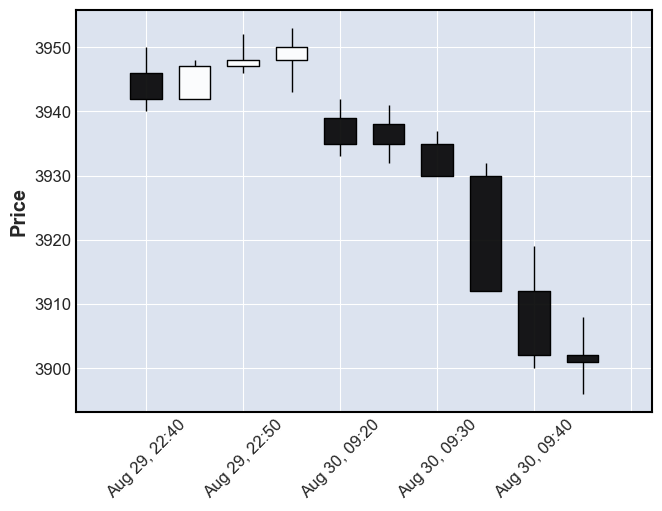

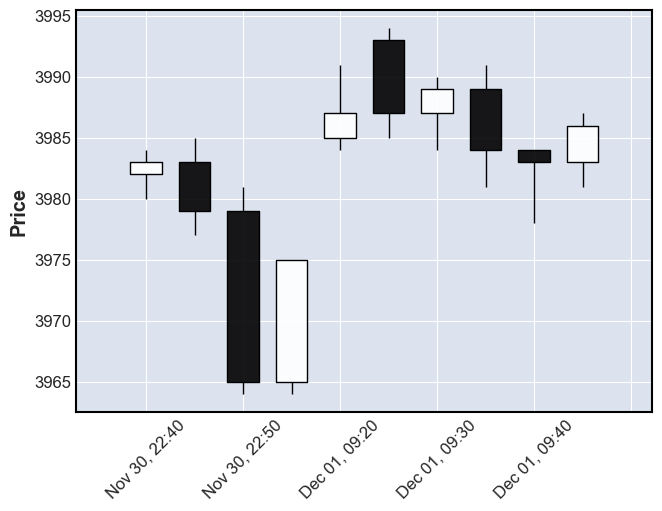

In [7]:
for i in range(1, len(contracts)):
    last_index_end = indexes[i-1][0][-5]
    this_index_start = indexes[i][0][5]
    tmp_df = train_df.iloc[last_index_end:this_index_start].set_index('date')
    tmp_df.index = pd.to_datetime(tmp_df.index)
    mpf.plot(tmp_df, type='candle')

# Get All Features

In [8]:
window_size = 90
individual_length = train_df[train_df.tic==tickers[0]].shape[0]
columns = get_factors(train_df[:window_size+5]).columns.to_list()
res_list = []
def data_processing(i, tmp_df):
    tmp_df_1 = tmp_df.iloc[i:i+window_size].copy()
    res = get_factors(tmp_df_1)
    clear_output()
    return res.iloc[-1].to_numpy()
for a in range(len(tickers)):
    tmp_df = train_df[train_df.tic==tickers[a]]
    res = Parallel(n_jobs=40)(delayed(data_processing)(i, tmp_df) for i in tqdm(range(individual_length-window_size)))
    res_list.append(res)
res_array = np.asarray(res_list)
res_array = res_array.reshape(res_array.shape[0]*res_array.shape[1], res_array.shape[-1])
res_df = pd.DataFrame(res_array)
res_df.columns = columns
for i in range(2, len(res_df.columns)):
    try:
        res_df[columns[i]] = res_df[columns[i]].values.astype('float64')
    except:
        print("Error: ", columns[i])
        res_df = res_df.drop(columns=columns[i])

res_df.shape, res_df.dtypes, res_df.head(5)

100%|██████████████████████████████████████████████████████████████████████████████| 6468/6468 [04:57<00:00, 21.77it/s]


Error:  underlaying_symbols


((6468, 75),
 date                 object
 tic                  object
 open                float64
 high                float64
 low                 float64
 close               float64
 volume              float64
 open_oi             float64
 close_oi            float64
 kmid                float64
 klen                float64
 kmid2               float64
 kup                 float64
 kup2                float64
 klow                float64
 klow2               float64
 ksft                float64
 ksft2               float64
 kmax_3              float64
 kmax_5              float64
 kmax_8              float64
 kmax_13             float64
 kmax_21             float64
 kmax_34             float64
 kmax_55             float64
 kmax_88             float64
 klow_3              float64
 klow_5              float64
 klow_8              float64
 klow_13             float64
 klow_34             float64
 klow_55             float64
 klow_88             float64
 rsv_3               float64
 

# Drop Features with Too Many Zeros
## If data set contains too many zeros, the agent will be very reluctant to trade.

In [9]:
columns = res_df.columns
zeros = ((res_df==0).sum()>res_df.shape[0]*0.05)
columns_to_drop = np.where(zeros==True)[0]

columns_to_drop.shape

(17,)

In [10]:
for i in range(columns_to_drop.shape[0]):
    tmp_index = columns_to_drop[i]
    tmp_column = columns[tmp_index]
    res_df = res_df.drop(columns=tmp_column)

res_df.isna().sum(), res_df.shape, res_df.columns, res_df.head(5), res_df.tail(5)

(date                0
 tic                 0
 open                0
 high                0
 low                 0
 close               0
 volume              0
 open_oi             0
 close_oi            0
 klen                0
 kmax_3              0
 kmax_5              0
 kmax_8              0
 kmax_13             0
 kmax_21             0
 kmax_34             0
 kmax_55             0
 kmax_88             0
 klow_3              0
 klow_5              0
 klow_8              0
 klow_13             0
 klow_34             0
 klow_55             0
 klow_88             0
 rsv_3               0
 rsv_5               0
 rsv_9               0
 rsv_13              0
 rsv_34              0
 rsv_55              0
 rsv_88              0
 corr_c_log_v_3      0
 corr_c_log_v_5      0
 corr_c_log_v_8      0
 corr_c_log_v_13     0
 corr_c_log_v_34     0
 corr_c_log_v_55     0
 corr_c_log_v_88     0
 corr_pc_pv_3        0
 corr_pc_pv_5        0
 corr_pc_pv_8        0
 corr_pc_pv_13       0
 corr_pc_pv

# Only Keep Valid Features

In [11]:
def IC_test(price, factor_values, shift=-1):
    next_term_return = pd.Series(price).pct_change().shift(shift).fillna(0).values
    factor_values = np.asarray(factor_values)
    factor_values = np.nan_to_num(factor_values)
    IC = np.corrcoef(factor_values, next_term_return)[0][-1]
    return IC

In [12]:
num_to_keep = 50
factors = res_df.columns[9:]
tickers = res_df.tic.unique()
corr_list = []
corr_df = pd.DataFrame()
for i in tqdm(range(len(factors))):
    tmp_corr_2 = []
    for a in tickers:
        tmp_df = res_df[res_df.tic==a]
        tmp_corr = IC_test(price=tmp_df.close.values, factor_values=tmp_df[factors[i]].values, shift=-1)
        tmp_corr_2.append(tmp_corr)
    corr_list.append(np.mean(tmp_corr))
        
corr_df['correlation'] = corr_list
corr_df['factors'] = factors
corr_df = corr_df.dropna()
corr_df = corr_df.drop(corr_df[corr_df.correlation==1].index)
corr_df = corr_df.sort_values(by="correlation",ascending=False)
valid_factors = []
valid_factors.append(corr_df.factors.values)
valid_factors = np.asarray(valid_factors)

corr_df.shape, corr_df.head(num_to_keep), valid_factors

100%|█████████████████████████████████████████████████████████████████████████████████| 49/49 [00:00<00:00, 196.66it/s]


((49, 2),
     correlation           factors
 2       0.03541            kmax_5
 1       0.03458            kmax_3
 3       0.02350            kmax_8
 9       0.02063            klow_3
 15      0.01884           klow_88
 4       0.01833           kmax_13
 12      0.01830           klow_13
 10      0.01398            klow_5
 11      0.01386            klow_8
 13      0.01322           klow_34
 5       0.00879           kmax_21
 26      0.00773   corr_c_log_v_13
 14      0.00730           klow_55
 35      0.00628     corr_pc_pv_55
 34      0.00467     corr_pc_pv_34
 6       0.00401           kmax_34
 45      0.00345  down_days_pct_13
 48      0.00335  down_days_pct_88
 38      0.00246     up_days_pct_8
 21      0.00203            rsv_55
 25      0.00153    corr_c_log_v_8
 0       0.00043              klen
 37     -0.00101     up_days_pct_5
 44     -0.00164   down_days_pct_8
 23     -0.00190    corr_c_log_v_3
 47     -0.00209  down_days_pct_55
 20     -0.00226            rsv_34
 33     -0

In [13]:
corr_df.to_csv(path+'新建文件夹\\corr_df_alpha_158.csv')
res_df.to_csv(path+'新建文件夹\\pre_processed_train_df_2_alpha_158.csv')